
# Classifier Comparison with Cross-Validation (Breast Cancer, scikit-learn)

This notebook prepares and compares different classifiers in a **binary classification** problem using the **Breast Cancer** dataset from `scikit-learn`.
Organization:

1. Load the dataset, split into **80% train/test (Xnew, ynew)** and **20% validation (Xval, yval)** (stratified).
2. Instantiate the classifiers: **KNN**, **Decision Tree**, **Naive Bayes**, **MLP**, and **SVM**.
3. Declare **hyperparameter grids** for each classifier (for `GridSearchCV`).
4. In a `for` loop, run **GridSearchCV** on the validation set (Xval, yval). After finding the best hyperparameters, train and test with **cross\_val\_score (5 folds)** using Xnew and ynew.
5. Display the **confusion matrix** of the model with the **highest accuracy**.


In [ ]:

# Imports
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import cross_val_predict, cross_val_score

# Classificadores monolíticos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Ensembles
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb


import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:

# 1) Loading and spliting the dataset (80% - 20%, estratificado)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

Xnew, Xval, ynew, yval = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

X.shape, Xnew.shape, Xval.shape, ynew.value_counts(normalize=True), yval.value_counts(normalize=True)


((569, 30),
 (455, 30),
 (114, 30),
 target
 1    0.626374
 0    0.373626
 Name: proportion, dtype: float64,
 target
 1    0.631579
 0    0.368421
 Name: proportion, dtype: float64)

In [ ]:

# 2) Classifiers and
# 3) Grids of Hyperparameters for GridSearchCV

models = {
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())]),

    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),

    "NaiveBayes": GaussianNB(),

    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=1000, random_state=RANDOM_STATE))]),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, random_state=RANDOM_STATE))
    ]),

    "RF": RandomForestClassifier(random_state=RANDOM_STATE),

    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),

    "Bagging": BaggingClassifier(random_state=RANDOM_STATE),

    "Xgboost" : xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE)
}

param_grids = {
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "NaiveBayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    },
    "MLP": {
        "clf__hidden_layer_sizes": [(20,), (15,), (15,10), (50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [1e-4, 1e-3, 1e-2],
        "clf__learning_rate_init": [1e-3, 1e-2],
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["rbf", "linear", "poly"],
        "clf__gamma": ["scale", "auto"],
    },

    "RF": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.1, 0.5, 1.0],
    },
    "Bagging": {
        "n_estimators": [50, 100, 200],
        "max_samples": [0.5, 0.75, 1.0],
    },
    "Xgboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.1, 0.5, 1.0],
    }
}


In [ ]:

# 4) Loop de GridSearchCV (cv=5) in the validation set (Xval, yval) e training/testing using cross-validation (cv=5) on the (Xnew, ynew) set.

results = []
best_models = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    grid = param_grids[name]

    gs = GridSearchCV(
        estimator=model,
        param_grid=grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=0,
        return_train_score=False,
    )
    gs.fit(Xval, yval)

    best_models[name] = gs.best_estimator_
    print("Melhores hiperparâmetros:", gs.best_params_)

    # Using cross_validation to evaluate the performance
    cv_scores = cross_val_score(gs.best_estimator_, Xnew, ynew, cv=5)
    print("Cross-val (5 folds) média de acurácia:", f"{cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Predictions based on cross_validation
    y_pred = cross_val_predict(gs.best_estimator_, Xnew, ynew, cv=5)

    acc  = accuracy_score(ynew, y_pred)
    prec = precision_score(ynew, y_pred, average="binary")
    rec  = recall_score(ynew, y_pred, average="binary")
    f1   = f1_score(ynew, y_pred, average="binary")

    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    })


=== KNN ===
Melhores hiperparâmetros: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'}
Cross-val (5 folds) média de acurácia: 0.9670 (+/- 0.0251)

=== DecisionTree ===
Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Cross-val (5 folds) média de acurácia: 0.9231 (+/- 0.0120)

=== NaiveBayes ===
Melhores hiperparâmetros: {'var_smoothing': 1e-09}
Cross-val (5 folds) média de acurácia: 0.9363 (+/- 0.0044)

=== MLP ===
Melhores hiperparâmetros: {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (15, 10), 'clf__learning_rate_init': 0.01}
Cross-val (5 folds) média de acurácia: 0.9736 (+/- 0.0204)

=== SVM ===
Melhores hiperparâmetros: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Cross-val (5 folds) média de acurácia: 0.9670 (+/- 0.0139)

=== RF ===
Melhores hiperparâmetros: {'max_depth': None, 'n_estimators': 50}
Cross-val (5 folds) média de acurácia: 0.9516 (+/- 0.025

Best Model (accuracy): MLP — 0.9736


<Figure size 500x500 with 0 Axes>

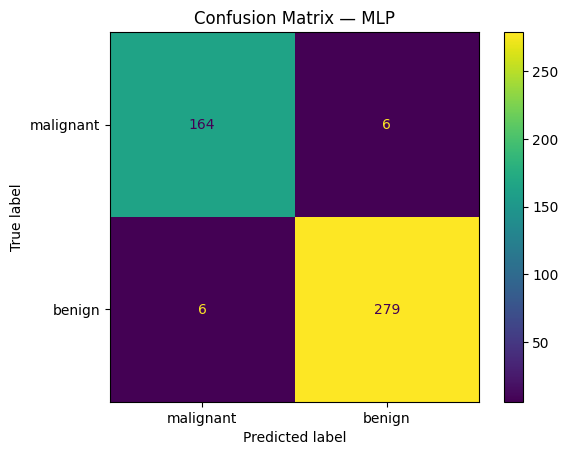


Classification Report (Best model):
              precision    recall  f1-score   support

   malignant       0.96      0.96      0.96       170
      benign       0.98      0.98      0.98       285

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



In [ ]:
# 5) & 6) Confusion matriz of the best model

# Convert results to a DataFrame to easily find the best model
df_results = pd.DataFrame(results)

# Find the best model by accuracy
best_name = df_results.loc[df_results["accuracy"].idxmax()]["model"]
best_estimator = best_models[best_name]

print(f"Best Model (accuracy): {best_name} — {df_results.loc[df_results['accuracy'].idxmax()]['accuracy']:.4f}")

# Predictions based on cross-validation
y_pred_best = cross_val_predict(best_estimator, Xnew, ynew, cv=5)
cm = confusion_matrix(ynew, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
fig = plt.figure(figsize=(5, 5))
disp.plot(values_format='d', cmap=None)
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

print("\nClassification Report (Best model):")
print(classification_report(ynew, y_pred_best, target_names=data.target_names))

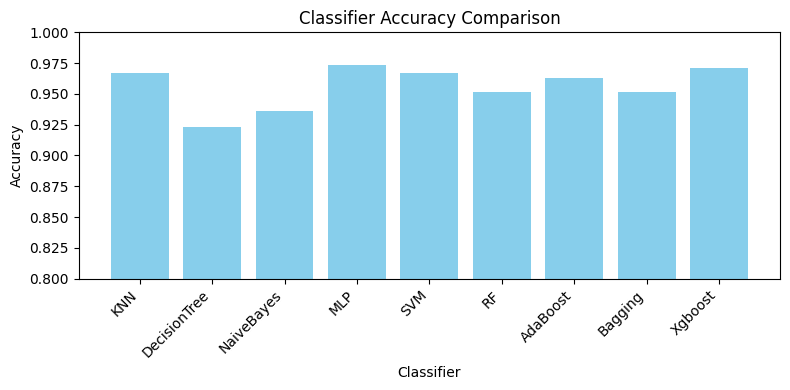

In [ ]:
# Generate a bar plot to compare the accuracy of the classifiers
plt.figure(figsize=(8, 4))
plt.bar(df_results['model'], df_results['accuracy'], color='skyblue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Set y-axis limit for better visualization of differences
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()